In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pycaret.regression import *
from pycaret.datasets import get_data
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx


In [2]:
df = pd.read_csv("model_input.csv", delimiter=";")
df.drop(['location'],axis=1,inplace=True)
df = df[df['lceq_avg'] != 0]
df.tail()

month  day_month  day_week  hour  minute  LC_HUMIDITY  LC_DWPTEMP  \
52555     12         31         6    23      10           53        7.06   
52556     12         31         6    23      20           53        6.97   
52557     12         31         6    23      30           53        6.99   
52558     12         31         6    23      40           53        6.82   
52559     12         31         6    23      50           53        6.75   

       LC_n  LC_RAD  LC_RAININ  ...   LC_TEMP  avg_trucks  avg_cars  \
52555    38       0        0.0  ...  16.63219         0.0       0.0   
52556    37       0        0.0  ...  16.61295         0.0       0.0   
52557    38       0        0.0  ...  16.53810         0.0       0.0   
52558    37       0        0.0  ...  16.39468         0.0       0.0   
52559    38       0        0.0  ...  16.26945         0.0       0.0   

       avg_bikes  avg_pedestrians  v85  Telraam data  Weather data  lceq_avg  \
52555        0.0              0.0  0.0             0             1   61.6704   
52556        0.0              0.0  0.0             0             1   63.0117   
52557        0.0              0.0  0.0             0             1   63.7770   
52558        0.0              0.0  0.0             0             1   66.1730   
52559        0.0              0.0  0.0             0             1   63.2617   

       lcpeak_avg  
52555     74.5478  
52556     76.6934  
52557     77.4834  
52558     80.3168  
52559     76.8943  

[5 rows x 24 columns]

In [3]:
# split into training and testing data
x_train, x_test, y_train, y_test = train_test_split(df.drop(['lceq_avg','lcpeak_avg'],axis=1), df['lceq_avg'], test_size=0.2, random_state=40)

## MLP Classifier

In [24]:
# MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30))
mlp.fit(x_train,y_train)

print("r2_score: ", r2_score(y_test, mlp.predict(x_test)))



r2_score:  0.7618968669344361


C:\Users\jadoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## CatBoost (High performance Gradient Boosting)

In [4]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=6, loss_function='RMSE', random_seed=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("R-squared score on test data: {:.2f}".format(model.score(x_test, y_test)))
# other metrics
print("Mean squared error on test data: {:.2f}".format(np.mean((y_pred - y_test)**2)))

0:	learn: 5.4847360	total: 157ms	remaining: 5m 14s
1:	learn: 5.2981341	total: 163ms	remaining: 2m 43s
2:	learn: 5.1200237	total: 171ms	remaining: 1m 53s
3:	learn: 4.9564412	total: 178ms	remaining: 1m 28s
4:	learn: 4.8044033	total: 188ms	remaining: 1m 14s
5:	learn: 4.6580154	total: 198ms	remaining: 1m 5s
6:	learn: 4.5217534	total: 207ms	remaining: 58.8s
7:	learn: 4.3933705	total: 213ms	remaining: 52.9s
8:	learn: 4.2773854	total: 234ms	remaining: 51.7s
9:	learn: 4.1677556	total: 240ms	remaining: 47.8s
10:	learn: 4.0599470	total: 247ms	remaining: 44.7s
11:	learn: 3.9662854	total: 254ms	remaining: 42.1s
12:	learn: 3.8733065	total: 261ms	remaining: 39.9s
13:	learn: 3.7862440	total: 271ms	remaining: 38.4s
14:	learn: 3.7093923	total: 279ms	remaining: 36.9s
15:	learn: 3.6411933	total: 287ms	remaining: 35.5s
16:	learn: 3.5702376	total: 292ms	remaining: 34.1s
17:	learn: 3.5063771	total: 301ms	remaining: 33.1s
18:	learn: 3.4512998	total: 308ms	remaining: 32.2s
19:	learn: 3.3975909	total: 315ms	re

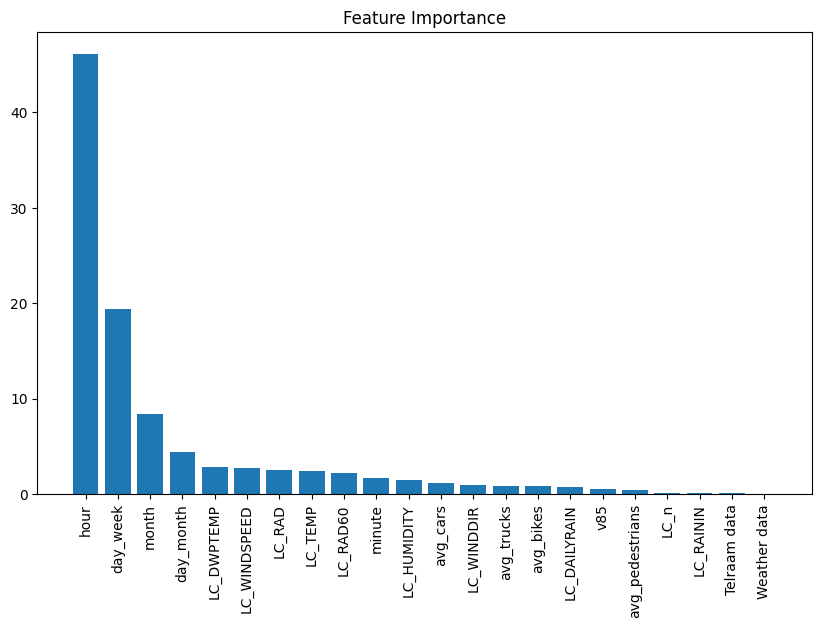

In [6]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [df.columns[i] for i in indices]
plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), names, rotation=90)
plt.show()



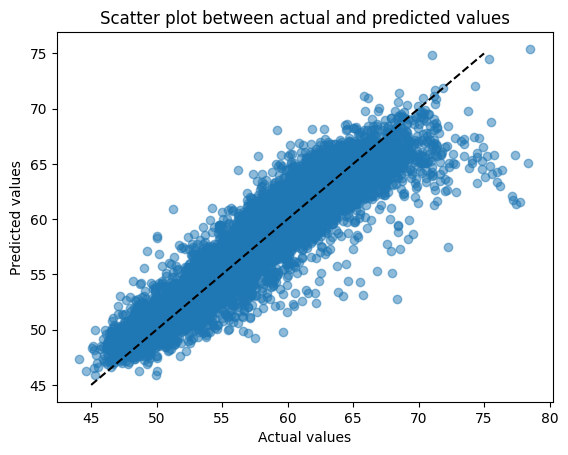

In [15]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([45, 75], [45, 75], '--k')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter plot between actual and predicted values")
plt.show()


## ADA Boost

In [12]:
# ADA Boost
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6),
                            n_estimators=400, random_state=42)
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
print("R-squared score on test data: {:.2f}".format(regr.score(x_test, y_test)))


R-squared score on test data: 0.74


## Naive Bayes

In [16]:
y_train_class = y_train.apply(lambda x: 1 if x>=50 else 0)
y_test_class = y_test.apply(lambda x: 1 if x>=50 else 0)

gnb = GaussianNB()
gnb.fit(x_train, y_train_class)

# make predictions and evaluate model performance
y_pred = gnb.predict(x_test)
print("R-squared score on test data: {:.2f}".format(gnb.score(x_test, y_test_class)))

R-squared score on test data: 0.80


## XGBoost (Extreme Gradient Boosting)

In [5]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print("R-squared score on test data: {:.2f}".format(xgb.score(x_test, y_test)))


R-squared score on test data: 0.87


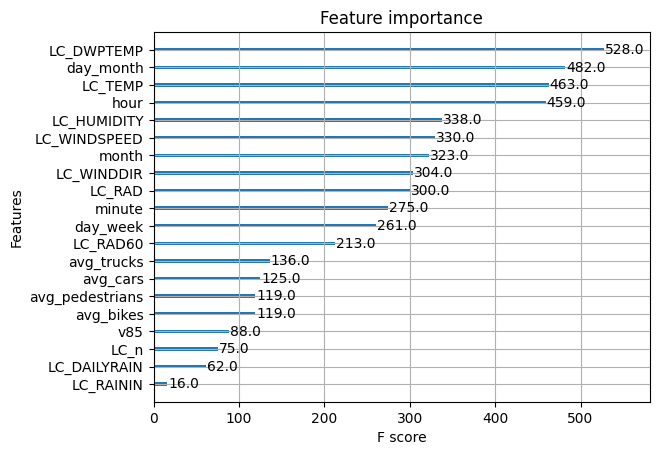

In [8]:
plot_importance(xgb)
plt.show()

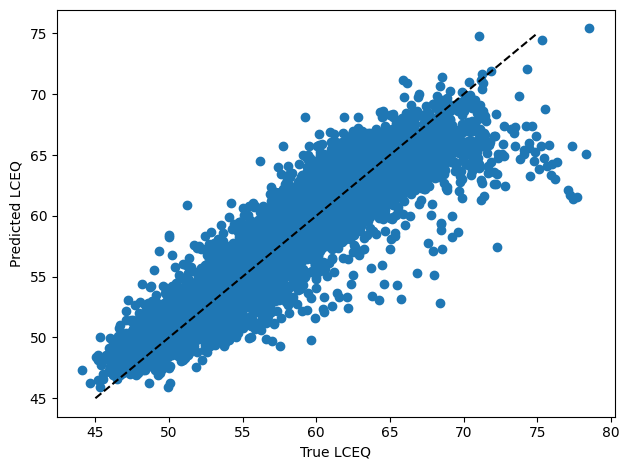

In [13]:
plt.scatter(y_test, y_pred)
plt.plot([45, 75], [45, 75], '--k')
plt.axis('tight')
plt.xlabel('True LCEQ')
plt.ylabel('Predicted LCEQ')
plt.tight_layout()
plt.show()

## K-Nearest Neighbor

In [18]:
# K nearest neighbors
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print("R-squared score on test data: {:.2f}".format(knn.score(x_test, y_test)))


R-squared score on test data: 0.62


## PyCaret Regression

In [3]:
## Setup pycaret environment, with the data being all columns except the target column
reg = setup(data = df.drop(['lceq_avg'],axis=1), target = 'lcpeak_avg', session_id=123, normalize=True, transformation=True)

In [4]:
top_models = compare_models()


Initiated  . . . . . . . . . . . . . . . . . .              11:35:36
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [5]:
print(top_models)

ExtraTreesRegressor(n_jobs=-1, random_state=123)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

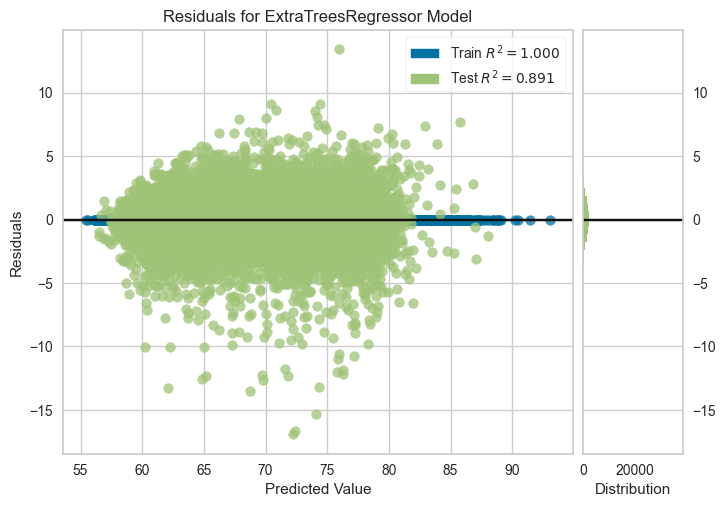

In [6]:
predict_model(top_models)
evaluate_model(top_models)
plot_model(top_models)

# Some More Analysis

### Correlation Matrix

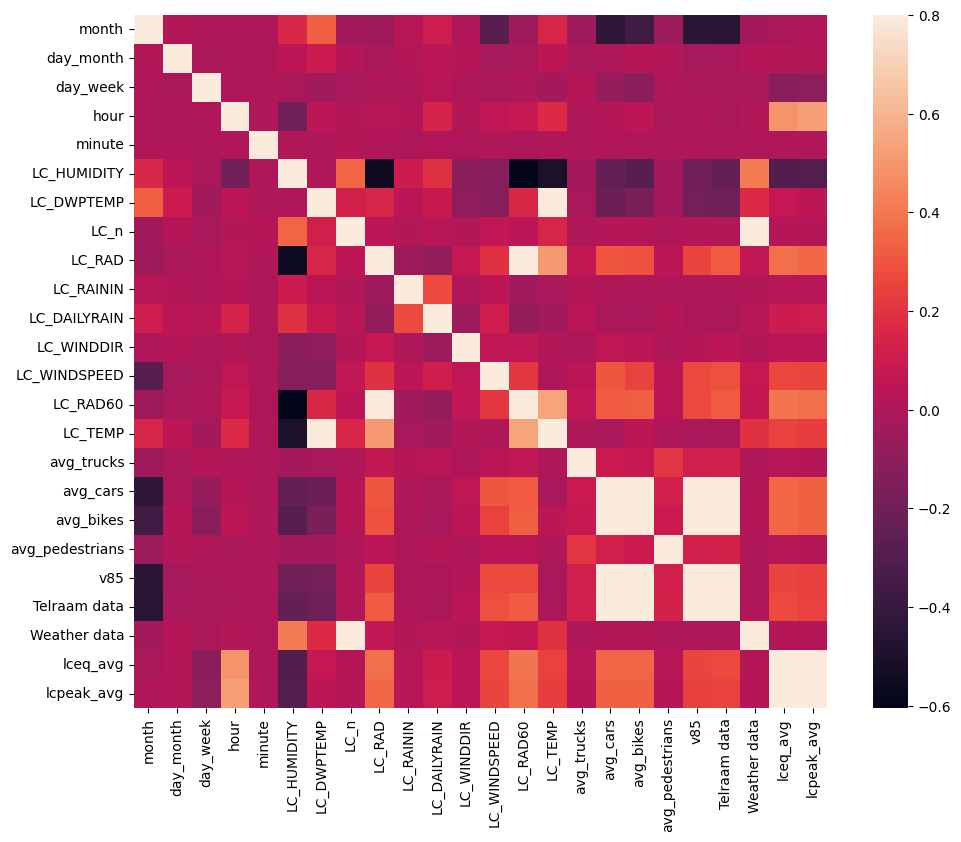

In [5]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()


### Distribution Plot

C:\Users\jadoh\AppData\Local\Temp\ipykernel_16388\422390722.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['lceq_avg'], kde=True)


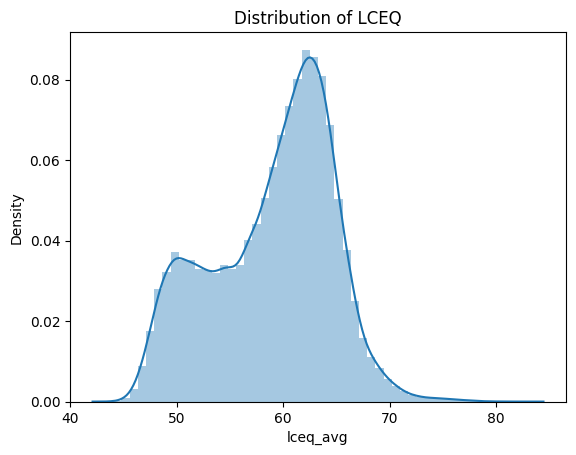

In [5]:
sns.distplot(df['lceq_avg'], kde=True)
plt.title("Distribution of LCEQ")
plt.show()


In [7]:
# Top 10 loudest lcpeak_avg in the year
df.sort_values(by=['lcpeak_avg'], ascending=False).head(10)



month  day_month  day_week  hour  minute  LC_HUMIDITY  LC_DWPTEMP   
26549      7          4         1     8      50           60       12.67  \
7012       2         18         5    16      40           57        2.24   
2496       1         18         2     8       0           99        4.92   
33884      8         24         3     7      20           81       17.94   
7015       2         18         5    17      10           57        1.65   
11415      3         21         1     6      30           94       -0.83   
7011       2         18         5    16      30           56        2.18   
11417      3         21         1     6      50           93       -0.56   
44977     11          9         3     8      10           87        9.89   
11416      3         21         1     6      40           93       -0.75   

       LC_n  LC_RAD  LC_RAININ  ...  LC_TEMP  avg_trucks  avg_cars  avg_bikes   
26549    38     477       0.00  ...    19.09        0.00      0.00       0.00  \
7012     38      20       0.00  ...    10.09        4.68     48.30      49.15   
2496     38       2       0.00  ...     5.09        8.72     33.69      34.16   
33884    37     107       0.00  ...    21.02        0.00      0.00       0.00   
7015     37       0       0.00  ...     9.64        0.00      0.00       0.00   
11415    38      23       0.00  ...     0.28        8.20     25.86      27.54   
7011     37      31       0.00  ...    10.42        4.68     48.30      49.15   
11417    38      36       0.00  ...     0.77        8.20     25.86      27.54   
44977    38      44       0.00  ...    12.07        0.00      0.00       0.00   
11416    37      29       0.00  ...     0.48        8.20     25.86      27.54   

       avg_pedestrians   v85  Telraam data  Weather data  lceq_avg  lcpeak_avg  
26549             0.00  0.00             0             1     82.52       93.04  
7012              1.70 30.00             1             1     78.54       91.41  
2496              4.00 38.00             1             1     79.24       90.49  
33884             0.00  0.00             0             1     79.43       90.25  
7015              0.00  0.00             0             1     77.77       90.18  
11415             0.42 37.00             1             1     78.35       89.39  
7011              1.70 30.00             1             1     76.71       89.36  
11417             0.42 37.00             1             1     78.25       89.15  
44977             0.00  0.00             0             1     79.62       89.09  
11416             0.42 37.00             1             1     78.17       89.02  

[10 rows x 24 columns]

In [6]:
# Top 10 loudest lceq_avg in the year
df.sort_values(by=['lceq_avg'], ascending=False).head(10)

month  day_month  day_week  hour  minute  LC_HUMIDITY  LC_DWPTEMP   
26549      7          4         1     8      50           60       12.67  \
26877      7          6         3    15      30           50       11.95   
44977     11          9         3     8      10           87        9.89   
33884      8         24         3     7      20           81       17.94   
2496       1         18         2     8       0           99        4.92   
31036      8          4         4    12      40           67       18.83   
7012       2         18         5    16      40           57        2.24   
31035      8          4         4    12      30           68       18.63   
11415      3         21         1     6      30           94       -0.83   
11417      3         21         1     6      50           93       -0.56   

       LC_n  LC_RAD  LC_RAININ  ...  LC_TEMP  avg_trucks  avg_cars  avg_bikes   
26549    38     477       0.00  ...    19.09        0.00      0.00       0.00  \
26877    38     229       0.00  ...    21.97        0.00      0.00       0.00   
44977    38      44       0.00  ...    12.07        0.00      0.00       0.00   
33884    37     107       0.00  ...    21.02        0.00      0.00       0.00   
2496     38       2       0.00  ...     5.09        8.72     33.69      34.16   
31036    37     462       0.00  ...    24.87        0.00      0.00       0.00   
7012     38      20       0.00  ...    10.09        4.68     48.30      49.15   
31035    38     380       0.00  ...    24.32        0.00      0.00       0.00   
11415    38      23       0.00  ...     0.28        8.20     25.86      27.54   
11417    38      36       0.00  ...     0.77        8.20     25.86      27.54   

       avg_pedestrians   v85  Telraam data  Weather data  lceq_avg  lcpeak_avg  
26549             0.00  0.00             0             1     82.52       93.04  
26877             0.00  0.00             0             1     80.64       87.28  
44977             0.00  0.00             0             1     79.62       89.09  
33884             0.00  0.00             0             1     79.43       90.25  
2496              4.00 38.00             1             1     79.24       90.49  
31036             0.00  0.00             0             1     78.57       88.53  
7012              1.70 30.00             1             1     78.54       91.41  
31035             0.00  0.00             0             1     78.36       88.84  
11415             0.42 37.00             1             1     78.35       89.39  
11417             0.42 37.00             1             1     78.25       89.15  

[10 rows x 24 columns]

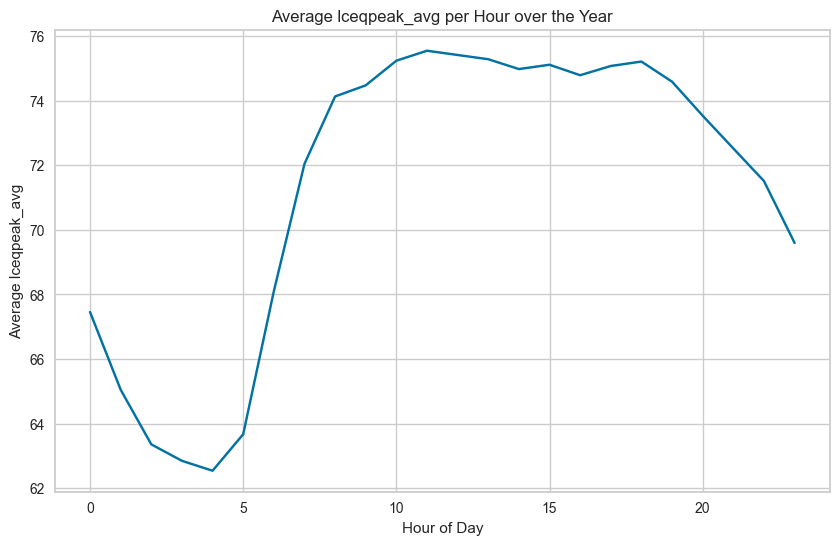

In [11]:

hourly_avg = df.groupby('hour')['lcpeak_avg'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values)
plt.xlabel('Hour of Day')
plt.ylabel('Average lceqpeak_avg')
plt.title('Average lceqpeak_avg per Hour over the Year')
plt.grid(True)
plt.show()

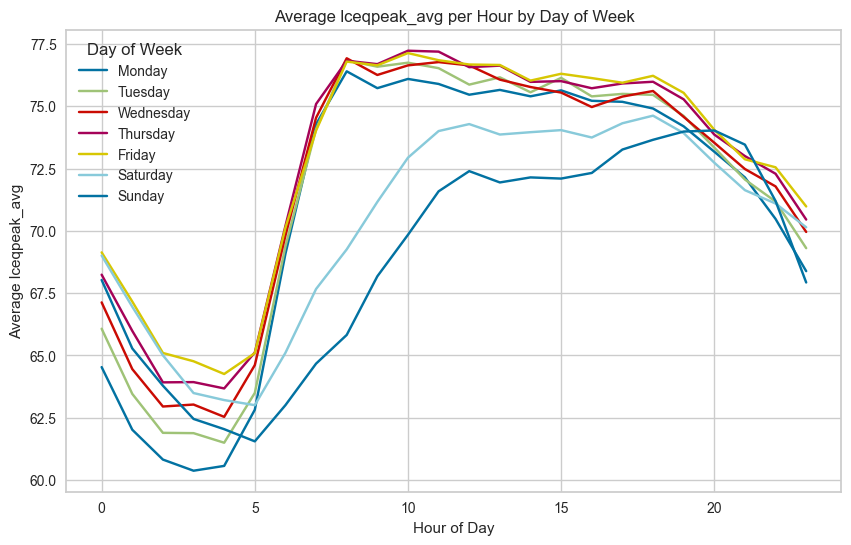

In [59]:
hourly_avg = df.groupby(['day_week', 'hour'])['lcpeak_avg'].mean().unstack(level=0)

plt.figure(figsize=(10, 6))
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in hourly_avg.columns:
    plt.plot(hourly_avg.index, hourly_avg[day], label=day_labels[day-1])

plt.xlabel('Hour of Day')
plt.ylabel('Average lceqpeak_avg')
plt.title('Average lceqpeak_avg per Hour by Day of Week')
plt.grid(True)
plt.legend(title='Day of Week')
plt.show()


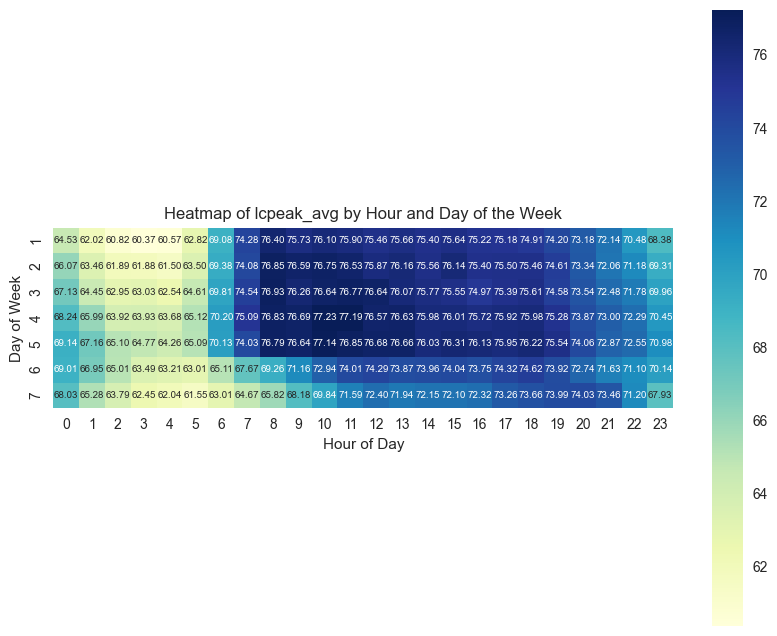

In [21]:
heatmap_data = df.pivot_table(index='day_week', columns='hour', values='lcpeak_avg')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', square=True, annot=True, fmt=".2f", annot_kws={'fontsize': 7}, cbar=True)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Heatmap of lcpeak_avg by Hour and Day of the Week')
plt.show()


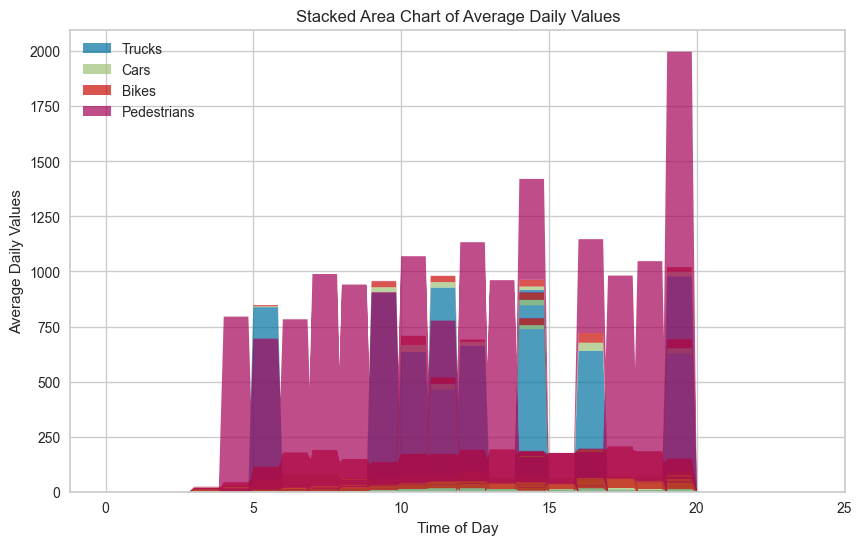

In [22]:
time = df['hour'] + (df['minute'] / 60)
avg_trucks = df['avg_trucks']
avg_cars = df['avg_cars']
avg_bikes = df['avg_bikes']
avg_pedestrians = df['avg_pedestrians']

# Plotting the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(time, avg_trucks, avg_cars, avg_bikes, avg_pedestrians,
              labels=['Trucks', 'Cars', 'Bikes', 'Pedestrians'],
              alpha=0.7)
plt.xlabel('Time of Day')
plt.ylabel('Average Daily Values')
plt.title('Stacked Area Chart of Average Daily Values')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

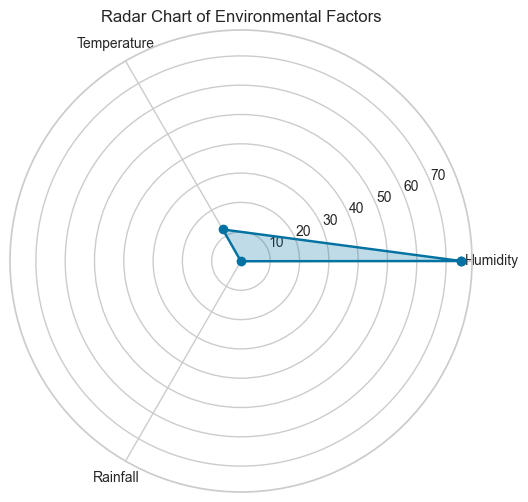

In [23]:
humidity = df['LC_HUMIDITY']
temperature = df['LC_TEMP']
rainfall = df['LC_RAININ']

labels = ['Humidity', 'Temperature', 'Rainfall']
values = [np.mean(humidity), np.mean(temperature), np.mean(rainfall)]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

plt.figure(figsize=(6, 6))
plt.polar(angles, values, marker='o')
plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], labels)
plt.title('Radar Chart of Environmental Factors')
plt.show()

In [68]:
# Treemap of lceqpeak_avg by day of week by hour
fig = px.treemap(df, path=['day_week', 'hour'], values='lcpeak_avg')
fig.show()



In [9]:
# More plots
fig = px.scatter(df, x="hour", y="lcpeak_avg", color="day_week",
                    size='lcpeak_avg', hover_data=['lcpeak_avg'])   
fig.show()


In [19]:
fig = px.density_heatmap(df, x="hour", y="day_week", z="lcpeak_avg", marginal_x="histogram", marginal_y="histogram", histfunc='avg')
fig.show()
